In [72]:
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [26]:
# Load the data. It has been re-ordered such that each replicate is one row.
df = pd.read_csv('biofilm_mod.csv')
le = LabelEncoder()
df['indices'] = le.fit_transform(df['isolate'])
df.head()

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement,indices
0,1,1,4,0.461,0.317,1,0.687636,0
1,1,2,55,0.346,0.434,1,1.254335,7
2,1,3,55,0.356,0.917,1,2.575843,8
3,1,4,4,0.603,1.061,1,1.759536,9
4,1,5,330,0.444,3.701,1,8.335586,10


In [27]:
le.classes_

array(['1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6',
       '7', '8', '9', 'ATCC_29212'], dtype=object)

In [30]:
# Formulate BEST model.
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_one', lam=1/30) + 1
    
    fold = pm.Flat('fold', shape=max(df['indices']) + 1)
    
    var = pm.HalfCauchy('var', beta=1, shape=max(df['indices']) + 1)
    
    mu = fold[df['indices']]
    sd = var[df['indices']]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, observed=df['normalized_measurement'])

Applied log-transform to nu_minus_one and added transformed nu_minus_one_log_ to model.
Applied log-transform to var and added transformed var_log_ to model.


In [31]:
# Estimate posterior distribution using ADVI (fast)
with best:
    params = pm.variational.advi(n=100000)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -485.13
Iteration 10000 [10%]: Average ELBO = -222.11
Iteration 20000 [20%]: Average ELBO = -87.57
Iteration 30000 [30%]: Average ELBO = -64.28
Iteration 40000 [40%]: Average ELBO = -59.44
Iteration 50000 [50%]: Average ELBO = -59.18
Iteration 60000 [60%]: Average ELBO = -59.03
Iteration 70000 [70%]: Average ELBO = -59.1
Iteration 80000 [80%]: Average ELBO = -59.12
Iteration 90000 [90%]: Average ELBO = -59.16
Finished [100%]: Average ELBO = -59.17


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119367828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114923a20>]], dtype=object)

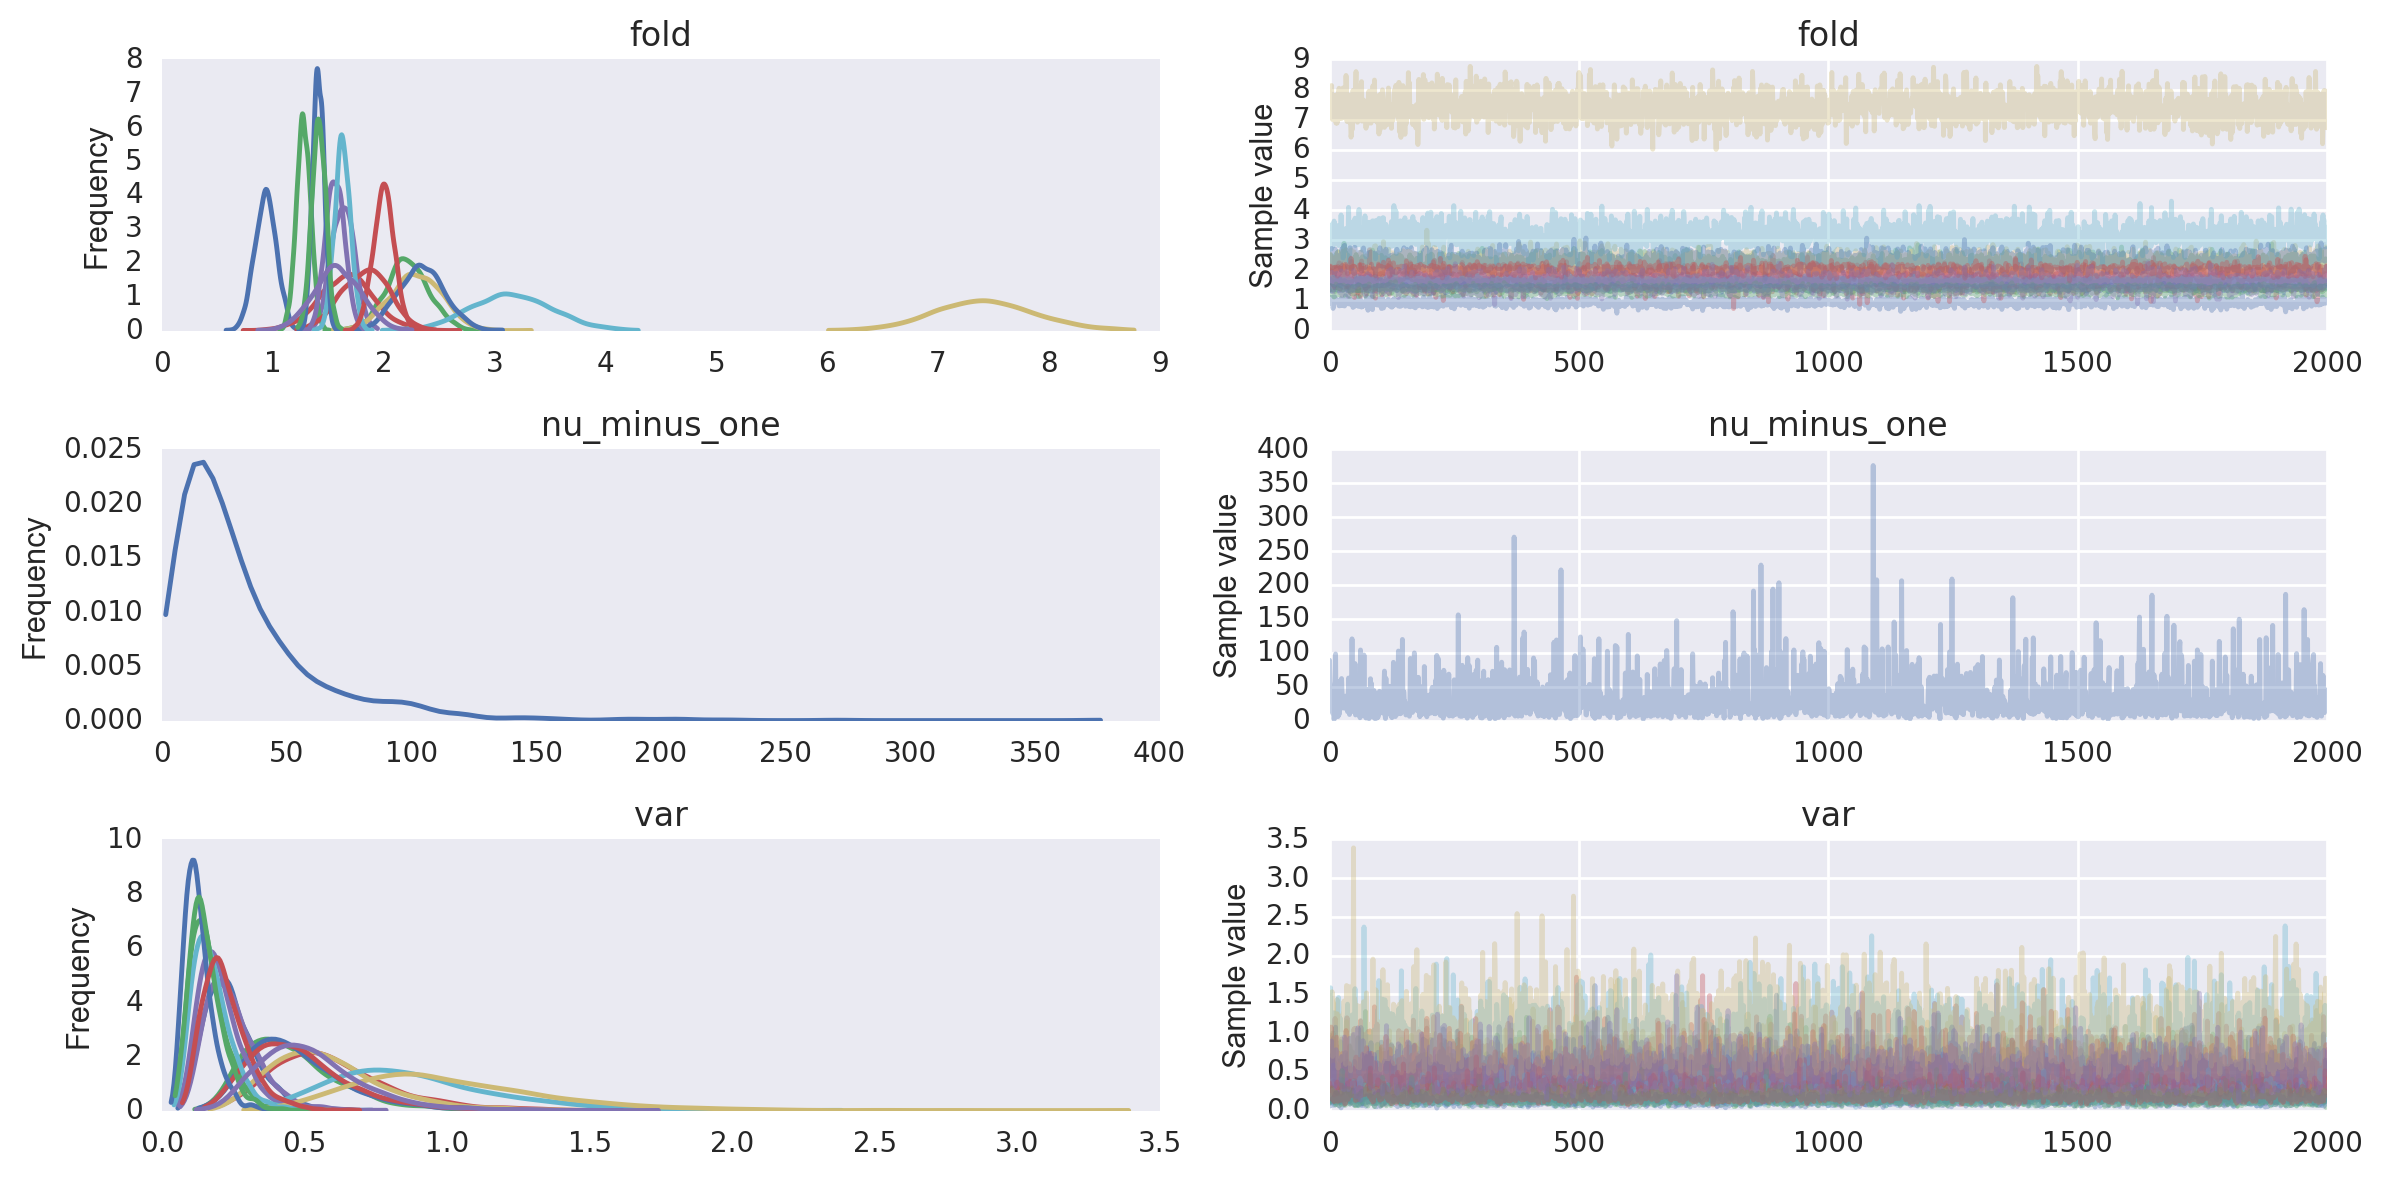

In [75]:
# Diagnostic plots, just to make sure things are okay.
pm.traceplot(trace)

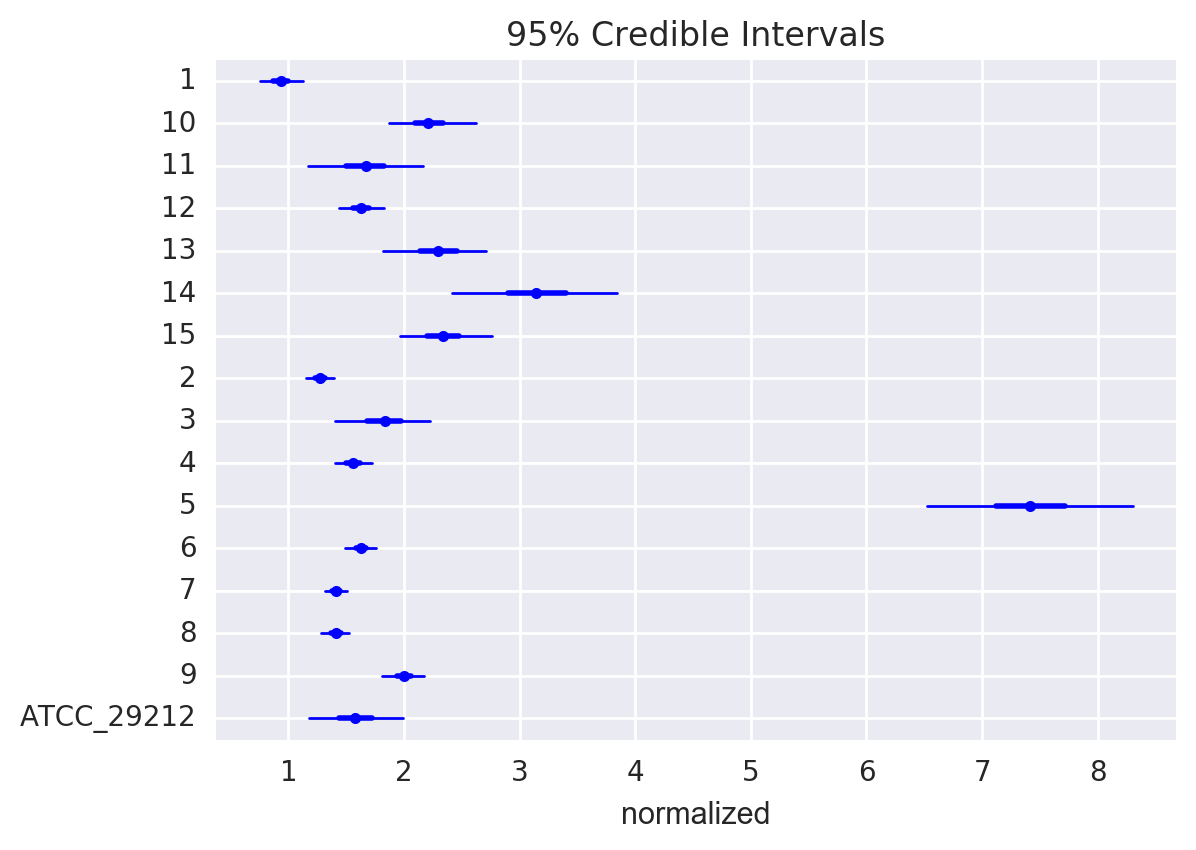

In [74]:
# Diagnostic plot, just to make sure things are okay.
pm.forestplot(trace, varnames=['fold'], ylabels=le.classes_, xtitle='normalized')

In [61]:
# Get out 95% HPD and IQR from trace.
hpd_low, iqr_low, median, iqr_high, hpd_high = np.percentile(trace['fold'], [2.5, 25, 50, 75, 97.5], axis=0)
hpd_upper = hpd_high - median
hpd_lower = median - hpd_low

iqr_upper = iqr_high - median
iqr_lower = median - iqr_low

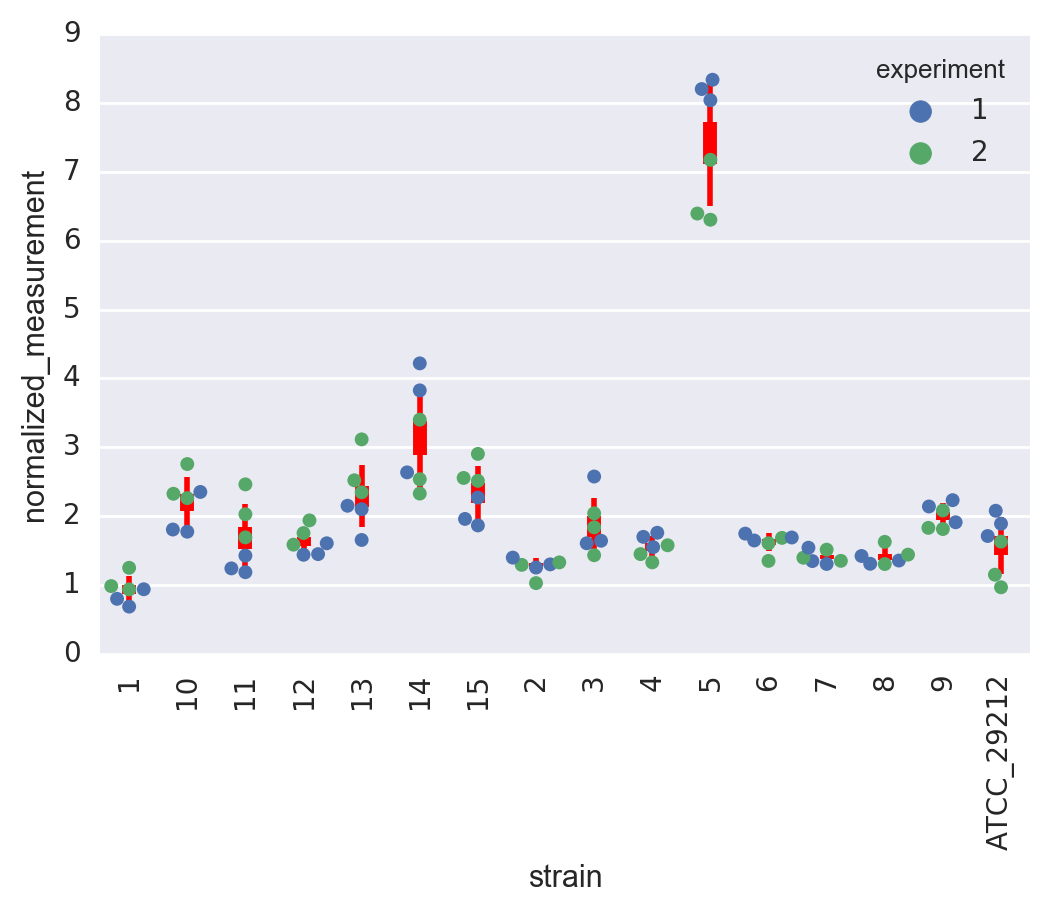

In [78]:
# Plot bee swarm plot + posterior distribution densities.
sns.swarmplot(data=df, x='indices', y='normalized_measurement', hue='experiment')
plt.errorbar(x=range(len(le.classes_)), y=median, yerr=[hpd_upper, hpd_lower], ls='none', color='red', elinewidth=2)
plt.errorbar(x=range(len(le.classes_)), y=median, yerr=[iqr_upper, iqr_lower], ls='none', color='red', elinewidth=5)
plt.xticks(range(len(le.classes_)), le.classes_, rotation=90)
plt.xlabel('strain')
plt.show()